In [153]:
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import pprint

import evo.core.transformations as tr

from copy import deepcopy
from evo.core import metrics, sync
from evo.core.trajectory import PosePath3D
from evo.tools import plot, file_interface

from tools.tum_tools import *
from tools.tum_plots import *
from tools.tum_definitions import *

%load_ext autoreload
%autoreload 2

%matplotlib inline
%matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!evo_traj tum ekf_pose_with_covariance.tum --ref in_pose_with_covariance.tum -p

# Initial Evaluation

In [83]:
# Load previously computed data
route = "mdv3_1"
data_root = f"data/pickle/{route}"

# gt_file = os.path.join(data_root, "full", "gt_poses.pkl")
gt_file = os.path.join("data", "reference", f"{route}_reference.tum")
traj_file = os.path.join(data_root, "full2", "kiss_trajectories_corrected_corr.pkl")
# traj_file = os.path.join(data_root, "full2", "kiss_trajectories.pkl")

# gt_dict = read_pickle(gt_file)
traj_dict = read_pickle(traj_file)

In [84]:
# Extract relevant data
current_key = "mdv3_full_merge"
# traj_ref = gt_dict['trajectory']
traj_ref = file_interface.read_tum_trajectory_file(gt_file)
traj_est = traj_dict[current_key][2]
traj = (traj_ref, traj_est)


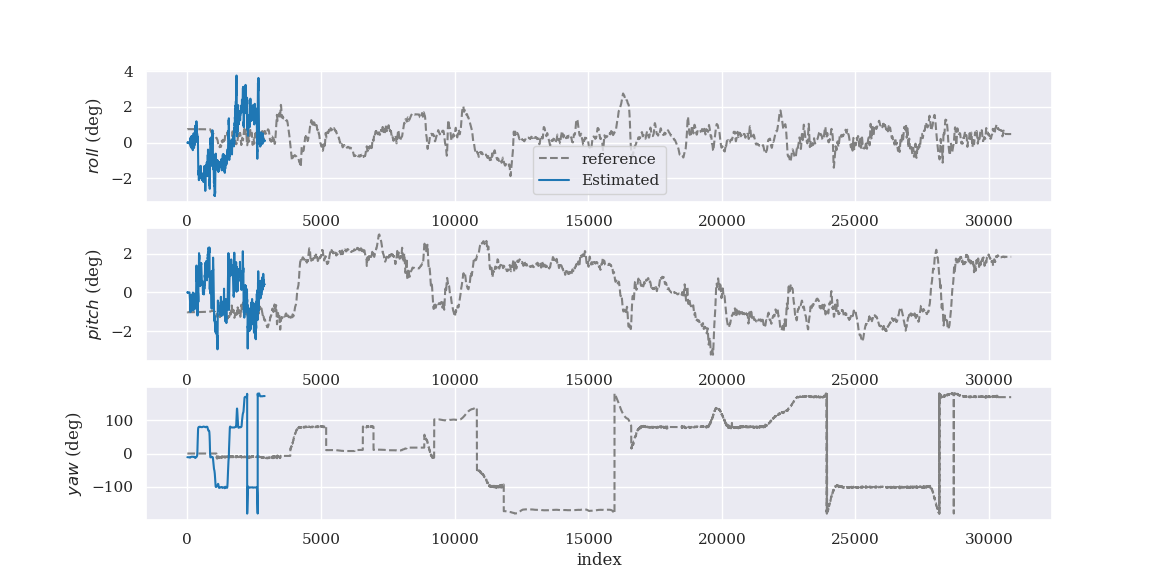

In [85]:
plot_compare(traj, print_stats=False, plot_mode='rpy')

In [ ]:
plt.savefig(f"figures/ape_{current_key}.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# PLOT THE FULL SET
max_diff = 0.01
results = {}

for recording in Mdv3Dataset:
    if traj_dict.get(recording.value) is None:
        print(f"Info: Did not found a recorded trajectory for {recording.value}")
        continue
    else:
        print(f"Processing: {recording.value}")

    traj_ref = gt_dict['trajectory']
    traj_est = traj_dict[recording.value][2]
    ape_stats = plot_compare((traj_ref, traj_est), plot_mode='ape', max_diff=max_diff)
    
    plt.savefig(f"tmp/ape_{recording.value}.pdf", format="pdf", bbox_inches="tight")
    results[recording.value] = ape_stats
    

In [ ]:
for recording, stats in results.items():
    print(f"Statistics for {recording}")
    pprint.pprint(stats)

In [ ]:
results

In [ ]:
import csv

fields = [ 'Type', 'max', 'mean', 'median', 'min', 'rmse', 'sse', 'std']


with open("test_output.csv", "w") as f:
    w = csv.DictWriter(f, fields)
    w.writeheader()
    for k in results:
        w.writerow({field: results[k].get(field) or k for field in fields})

In [ ]:
plot_trajectories_from_poses(traj_ref, traj_est)

# Analysis of KISS-ICP For Chapter 5

In [208]:
# Setup
route = "mdv3_2"
data_key = "mdv3_full_merge"

data_root = f"data/pickle/{route}"
uncorrected_traj_file = os.path.join(data_root, "kiss_trajectories.pkl")
preprocessed_traj_file = os.path.join(data_root, "kiss_trajectories_preprocessed.pkl")

reference_file = f"data/reference/{route}_reference.tum"

In [210]:
# Reading
uncorrected_traj = read_pickle(uncorrected_traj_file)[data_key][2]
preprocessed_traj = read_pickle(preprocessed_traj_file)[data_key][2]
reference_traj = file_interface.read_tum_trajectory_file(reference_file)

traj_est_original = uncorrected_traj
traj_ref = preprocessed_traj

In [211]:
rpy_rad = (next((rot for rot in traj_ref.get_orientations_euler() if math.fabs(rot[2]) > 1e-15)))
rpy_rad[0] = traj_ref.get_orientations_euler()[0][0]
rpy_rad[1] = traj_ref.get_orientations_euler()[0][1]
rpy_deg = [a * 180/math.pi for a in rpy_rad]
print(rpy_deg)

traj_est_aligned = deepcopy(traj_est_original)


origin_se3 = np.eye(4)
origin_se3[:3,:3] = R.from_euler("xyz", rpy_rad).as_matrix()
_ = traj_est_aligned.align_origin(PosePath3D(poses_se3=[origin_se3]))

# Estimation based on only the yaw angle (procedure earlier in the process)
traj_est_aligned_2 = tum_tools.align_origin(deepcopy(traj_est_original), yaw_deg= 281 if route=="mdv3_2" else 101)

[0.0, -0.0, 0.008457439198834358]


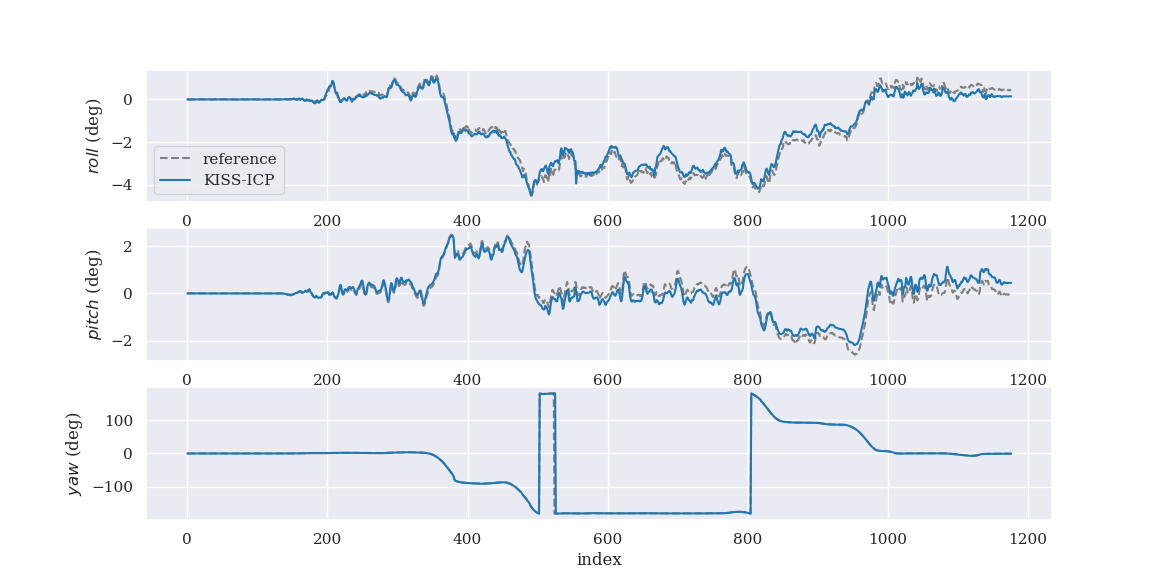

In [212]:

plot_compare((traj_ref, traj_est_aligned), print_stats=False, plot_mode='rpy', max_diff=0.1, est_name="KISS-ICP")
#plt.savefig(f"figures/eval/kiss_align/{route}_rpy_plot.pdf", format="pdf", bbox_inches="tight")
# plot_trajectories_from_poses(reference_traj, [uncorrected_traj, traj_est_aligned, traj_est_aligned_2], ["Uncorrected", "Aligned RPY", "Aligned Y"])

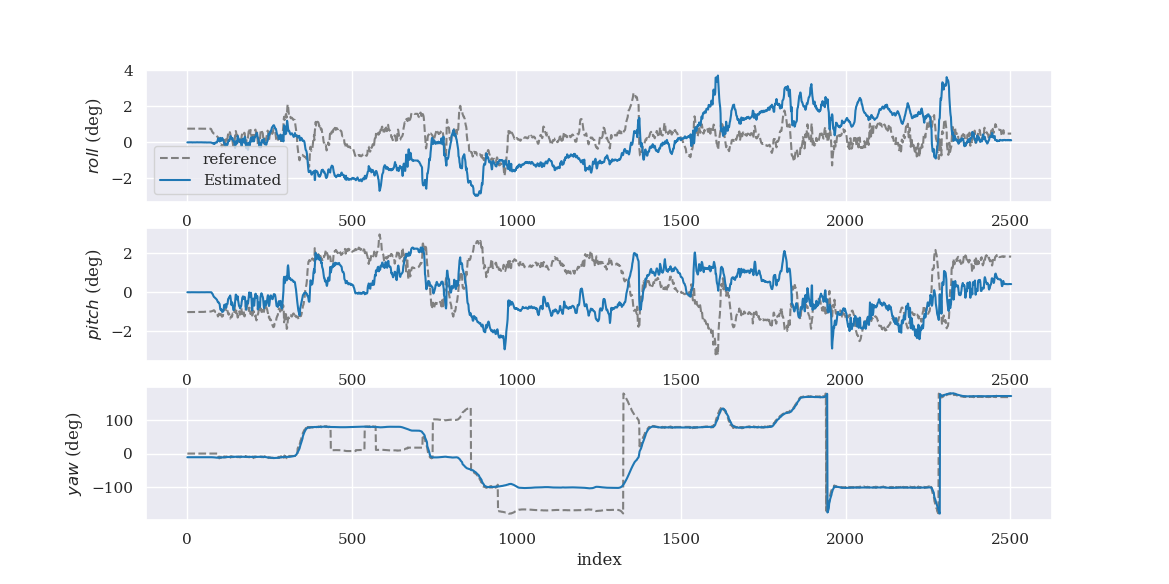

In [163]:
plot_compare((traj_ref, traj_est_aligned_2), print_stats=False, plot_mode='rpy', max_diff=0.01)